<a href="https://colab.research.google.com/github/flaviovdf/musica/blob/main/notebooks/lab07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Descomente para executar no colab
! pip install git+https://github.com/flaviovdf/musica.git

  Cloning https://github.com/flaviovdf/musica.git to /tmp/pip-req-build-ut3zz0v5
  Running command git clone --filter=blob:none --quiet https://github.com/flaviovdf/musica.git /tmp/pip-req-build-ut3zz0v5
  Resolved https://github.com/flaviovdf/musica.git to commit 19c84b84ab1cd1a6a6e0fdefbf33fc9c796c1949
  Preparing metadata (setup.py) ... done
  Created wheel for musica_dcc_ufmg: filename=musica_dcc_ufmg-0.1-py3-none-any.whl size=3384 sha256=636e26c966fc75244e4b1e7f3480a982d4089459b992048c478b651348ab3b34
  Stored in directory: /tmp/pip-ephem-wheel-cache-js4uyxzv/wheels/1b/27/be/d1dd5d3aaf79270e5186906cef2d3fa86055f27cecb4f4878a
Successfully built musica_dcc_ufmg


# Music Auto Tagging (Multi-Label Classification and Metric Learning Approach)


Music auto-tagging is an important task that can be used in many musical applications such as music search or recommender systems.

Two central methods for representation learning include deep metric learning and classification, both having the same goal of learning a representation that can generalize well across tasks.

Your mission is to build your own Neural Network model to represent audio signal. Specifically, the goals of this homework are as follows:

* Experiencing the whole pipeline of deep learning based system: data preparation, feature extraction, model training and evaluation
* Getting familiar with the Neural Network architectures for music representation
* Using Pytorch in practice

# Getting Ready

## Preparing The Dataset
We use the [magnatagatune](https://mirg.city.ac.uk/codeapps/the-magnatagatune-dataset) dataset which has been the most widely used in the music tagging task.  The MagnaTagATune dataset consists of 25k music
clips from 6,622 unique songs.

The dataset contains 30-second audio files including 189 different tags
For this homework, we are going to use a magnatagatune with 8-second audio and only 50 genres.

We use subset of magnatagatune dataset (9074 samples x 8 sec).

To make your life easier, place them in a directory as below:

```
├── annotations_final.csv
├── waveform
  ├── 1
  ├── ...
  └── d
```

## Importing Packages

In [2]:
from musica import mu_files
from musica import mu_plots

from glob import glob

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import librosa
import matplotlib.pyplot as plt
import numpy as np
import optax
import os
import pandas as pd

from sklearn.metrics import hamming_loss, accuracy_score, precision_score, recall_score, f1_score, jaccard_score

In [3]:
mu_files.download('https://dcc.ufmg.br/~flaviovdf/mir/lab07/files.zip', 'files.zip',
             False)
mu_files.extract('files.zip', '.')

files.zip: 300MB [01:07, 4.67MB/s]


In [4]:
mu_plots.init_matplotlib()
plt.ion()

## Enabling and testing the GPU

First, you'll need to enable GPUs for the Colab notebook:

- Navigate to Edit (수정) → Notebook Settings (노트 설정)
- select GPU from the Hardware Accelerator (하드웨어 가속기) drop-down

Next, we'll confirm that we can connect to the GPU with PyTorch and check versions of packages:

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


If the cell above throws an error, then you should enable the GPU following the instruction above!

# Data Checking


In [40]:
df = pd.read_csv('subset_magnatune.csv', index_col=0)
df.shape

(1048, 189)

In [41]:
df.head()

,no voice,singer,duet,plucking,hard rock,world,bongos,harpsichord,female singing,clasical,...,rap,metal,hip hop,quick,water,baroque,women,fiddle,english,mp3_path
clip_id,,,,,,,,,,,,,,,,,,,,,
29,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0/american_bach_soloists-j_s__bach__cantatas_v...
105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0/rocket_city_riot-last_of_the_pleasure_seeker...
293,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c/strojovna_07-number_1-01-ambi_crack-59-88.npy
294,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c/strojovna_07-number_1-01-ambi_crack-88-117.npy
303,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1/ambient_teknology-phoenix-01-ambient_teknolo...


[Text(0, 0.5, 'Frequência')]

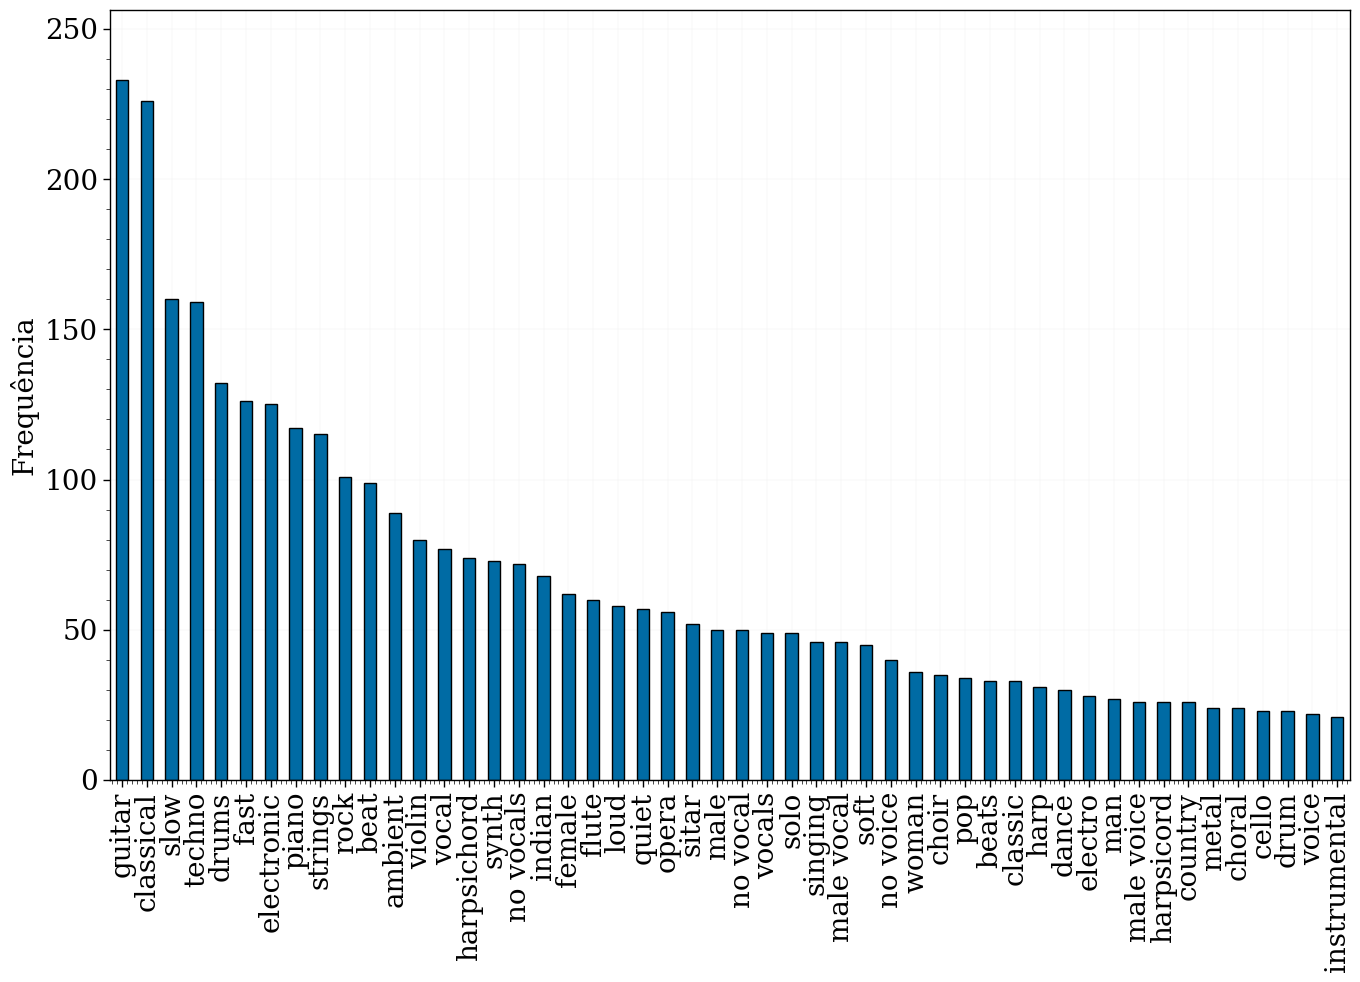

In [42]:
_, ax = plt.subplots(1, 1)
(df.iloc[:, :-1].sum().
 sort_values(ascending=False)[:50].
 plot.bar(ax=ax, rot=90, edgecolor='k')
)
ax.set(ylabel='Frequência')

In [43]:
top = (df.iloc[:, :-1].sum().
       sort_values(ascending=False)[:50]).index
top

Index(['guitar', 'classical', 'slow', 'techno', 'drums', 'fast', 'electronic',
       'piano', 'strings', 'rock', 'beat', 'ambient', 'violin', 'vocal',
       'harpsichord', 'synth', 'no vocals', 'indian', 'female', 'flute',
       'loud', 'quiet', 'opera', 'sitar', 'male', 'no vocal', 'vocals', 'solo',
       'singing', 'male vocal', 'soft', 'no voice', 'woman', 'choir', 'pop',
       'beats', 'classic', 'harp', 'dance', 'electro', 'man', 'male voice',
       'harpsicord', 'country', 'metal', 'choral', 'cello', 'drum', 'voice',
       'instrumental'],
      dtype='object')

In [44]:
df = df[[c for c in top] + ['mp3_path']]
df.shape

(1048, 51)

In [45]:
(df.drop(columns='mp3_path').sum(axis=1) == 0).any()

True

In [46]:
df = df[df.drop(columns='mp3_path').sum(axis=1) != 0]
df = df.sample(frac=1)
df.head()

,guitar,classical,slow,techno,drums,fast,electronic,piano,strings,rock,...,male voice,harpsicord,country,metal,choral,cello,drum,voice,instrumental,mp3_path
clip_id,,,,,,,,,,,,,,,,,,,,,
13060,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,b/the_bots-now_is_the_time-03-freak-204-233.npy
41006,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2/ensemble_mirable-conversations_galantes-09-s...
56856,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,a/da_camera-a_celtic_celebration-21-the_irish_...
42018,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,c/richard_savino-legrenzi__venice_before_vival...
33503,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,b/richard_savino-mertz__bardic_sounds-07-study...


In [47]:
train_df = df[:768]
val_df = df[768:896]
test_df = df[896:896+128]

print(train_df.shape, val_df.shape, test_df.shape)

(768, 51) (128, 51) (128, 51)


# Training CNNs from Scratch

The baseline code is provided so that you can easily start the homework and also compare with your own algorithm.
The baseline model extracts mel-spectrogram and has a simple set of CNN model that includes convolutional layer, batch normalization, maxpooling and fully-connected layer.

## Data Preprocessing

In [48]:
def to_mel_spectrum(wave, sr=16000, n_fft=516, n_mels=96, secs=6):
    S = librosa.feature.melspectrogram(y=wave[:secs * sr],
                                       sr=sr,
                                       n_fft=n_fft,
                                       n_mels=n_mels)
    S_dB = librosa.power_to_db(S)
    return S_dB

def load_data(file_paths):
    for fpath in file_paths:
        fpath = os.path.join('waveform', fpath)
        yield np.load(fpath)

In [52]:
data_train = list(map(to_mel_spectrum, load_data(train_df['mp3_path'])))
X_train = torch.tensor(data_train).unsqueeze(1)
Y_train = torch.tensor(train_df.drop('mp3_path', axis=1).values)

data_val = list(map(to_mel_spectrum, load_data(val_df['mp3_path'])))
X_val = torch.tensor(data_val).unsqueeze(1)
Y_val = torch.tensor(val_df.drop('mp3_path', axis=1).values)

data_test = list(map(to_mel_spectrum, load_data(test_df['mp3_path'])))
X_test = torch.tensor(data_test).unsqueeze(1)
Y_test = torch.tensor(test_df.drop('mp3_path', axis=1).values)

In [54]:
batch_size = 16
X_batches = X_train.reshape((X_train.shape[0] // batch_size,
                             batch_size,
                             X_train.shape[1], # channel dimension
                             X_train.shape[2],
                             X_train.shape[3]))
Y_batches = Y_train.reshape((Y_train.shape[0] // batch_size,
                             batch_size,
                             Y_train.shape[1]))

In [55]:
Xb, Yb = X_batches[0], Y_batches[0]
Xb.shape

torch.Size([16, 1, 96, 188])

In [104]:
Yb.shape

torch.Size([16, 50])

## Iterating in Batches

## Training a baseline
The table below shows the architecture of the baseline.

| Layer          | Output Size | Details                 |
|----------------|-------------|-------------------------|
| input          | B x 1 x 16000 * sec,    | batch x channel x samples |
| mel_spec       | B x 96 x 188    | batch x freq x time|
| conv + maxpool | B x 32 x 64    | kernel_size=3, stride=1 |
| conv + maxpool | B x 32 x 22    | kernel_size=3, stride=1 |
| conv + maxpool | B x 32 x 8     | kernel_size=3 stride=1 |
| global_avgpool | B x 32 x 1     | -                       |
| classifier     | B x 50         | -                       |

The class below is an implementation of it:

In [139]:
class Baseline(nn.Module):
    def __init__(self, input_channels=1):
        super(Baseline, self).__init__()

        self.conv_sequence = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=6, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1),
            nn.Conv2d(in_channels=16, out_channels=6, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1)
        )
        self.avg_pool = nn.AvgPool2d(kernel_size=(1, 1))

        self.fc_sequence = nn.Sequential(
            nn.Linear(in_features=6*84*176, out_features=50),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_sequence(x)
        x = self.avg_pool(x)
        x = x.reshape((x.shape[0], -1))  # flatten
        x = self.fc_sequence(x)
        return x

In [156]:
model = Baseline().to(device)
model

Baseline(
  (conv_sequence): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 6, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (avg_pool): AvgPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0)
  (fc_sequence): Sequential(
    (0): Linear(in_features=88704, out_features=50, bias=True)
    (1): Sigmoid()
  )
)

In [158]:
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [159]:
epochs = 50

for epoch in range(epochs):

    model.train()
    epoch_loss = 0.
    for Xb, Yb in zip(X_batches, Y_batches):
        Xb = Xb.float().to(device)
        Yb = Yb.float().to(device)

        optimizer.zero_grad()

        outputs = model(Xb)

        loss = criterion(outputs, Yb)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    if epoch % 10 == 0:
      print(f'Epoch {epoch} - Train Loss: {(epoch_loss/X_batches.shape[0]):.4f}', end='')

    with torch.no_grad():
        model.eval()

        X_val = X_val.float().to(device)
        Y_val = Y_val.float().to(device)

        outputs = model(X_val)
        loss_val = criterion(outputs, Y_val)
        epoch_loss = loss_val.item()

        if epoch % 10 == 0:
          print(f' - Val Loss: {(epoch_loss):.4f}')

Epoch 0 - Train Loss: 0.2904 - Val Loss: 0.2357
Epoch 10 - Train Loss: 0.2062 - Val Loss: 0.2143
Epoch 20 - Train Loss: 0.1920 - Val Loss: 0.2075
Epoch 30 - Train Loss: 0.1762 - Val Loss: 0.2030
Epoch 40 - Train Loss: 0.1571 - Val Loss: 0.2005


In [160]:
def auto_tagging(id, df, X, model, topk):
    row = df.iloc[id].copy()

    audio_sample = [row['mp3_path']]
    row = row.drop('mp3_path')
    wave = next(load_data(audio_sample))

    X_torch = torch.tensor(X[id], dtype=torch.float).unsqueeze(0).to(device)

    logit = model(X_torch)[0]

    idx_sorted = torch.argsort(logit, descending=True)
    idx_topk = idx_sorted[:topk]

    return wave, row.iloc[idx_topk.cpu().numpy()].index

In [161]:
import IPython.display as ipd

id = 30
wave, tags = auto_tagging(id, test_df, X_test, model, 5)
print(tags)
ipd.Audio(wave, rate=16000) # load a NumPy array

Index(['vocal', 'techno', 'slow', 'classical', 'harpsichord'], dtype='object')


<ipython-input-160-9f4d64a3623f>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_torch = torch.tensor(X[id], dtype=torch.float).unsqueeze(0).to(device)


### [Question 1] Implement the given architecture.
Implement a 2D CNN with the architecture below, train, and report a test accuracy of the 2D CNN.

| Layer          | Output Size | Details                 |
|----------------|-------------|-------------------------|
| input          | B x 1 x sample_rate * duration,    | batch x channel (mono) x samples |
| mel_spec       | B x 1 x 96 x 188    | batch x channel (mono) x freq x time|
| conv + maxpool | B x 64 x 24 x 47    | output_channels=64, kernel_size=3, pooling=(4,4) |
| conv + maxpool | B x 128 x 8 x 15    | output_channels=128, kernel_size=3, pooling=(3,3) |
| conv + maxpool | B x 128 x  2 x 5     | output_channels=128, kernel_size=3 pooling=(3,3) |
| conv + maxpool | B x 64 x 1 x 1      | output_channels=64, kernel_size=3 pooling=(2,5)                    |
| classifier     | B x 50         | -                       |


Note: you should give appropriate paddings!

### [Question 2] Improve the performenace.
Now it is your turn. You should improve the baseline code with your own algorithm. There are many ways to improve it. The followings are possible ideas:

* You can try 1D CNN or 2D CNN models and choose different model parameters:
    * Filter size
    * Pooling size
    * Stride size
    * Number of filters
    * Model depth
    * Regularization: L2/L1 and Dropout

* You should try different hyperparameters to train the model and optimizers:
    * Learning rate
    * Model depth
    * Optimizers: SGD (with Nesterov momentum), Adam, RMSProp, ...

* You can try training a model using both mel-spectrograms and features extracted using the pre-trained models. However, end-to-end training using additional external data is prohibited. (Performance doesn't have a huge impact on grading. don't waste time)


* You can try different parameters (e.g. hop and window size) to extract mel-spectrogram or different features as input to the network (e.g. MFCC, chroma features ...).

* You can also use ResNet or other CNNs with skip connections.

* Furthermore, you can augment data using digital audio effects.

### [Question 3] Improve the performance.
Now it is your turn. You should improve the baseline code with your own algorithm. There are many ways to improve it. The followings are possible ideas:

* Change backbone model
  - https://arxiv.org/abs/1711.02520
  - https://arxiv.org/abs/2006.00751